# Cryptocurrency Predictions

### Step 1: Import libraries

In [1]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Step 2: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [2]:
api_client = Coinpaprika.Client()

# get market overview
market_overview = api_client.global_market_overview()

# show 10 first coins
all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
usdt-tether
ada-cardano
doge-dogecoin
bnb-binance-coin
xrp-xrp
dot-polkadot
usdc-usd-coin
hex-hex


### Step 3: Get historical data 

In [3]:
# select one coin
coin = 'btc-bitcoin'
color = 'green'

# get historical data
hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)

# describe data
pd.options.display.float_format = '{:.2f}'.format
df = pd.DataFrame(hist)
df.describe()

,open,high,low,close,volume,market_cap
count,365.00,365.00,365.00,365.00,365.00,365.00
mean,26937.30,27721.58,26109.48,27018.72,35266270300.77,501370390708.44
std,18737.66,19331.54,18055.32,18725.75,22235371640.52,350737014751.42
min,8760.15,8966.77,8713.78,8844.51,10889324562.00,161054879708.00
25%,10799.18,10948.27,10656.33,10799.98,17111131795.00,199683056572.00
50%,17823.38,18403.17,17581.21,18083.91,25269010977.00,330593185826.00
75%,46772.91,48234.07,45132.93,46424.22,51868617502.00,871829542760.00
max,63675.35,65028.97,62214.97,63608.18,136370233019.00,1189580462018.00


In [4]:
# pack closing data into "alldata" array
alldata = []
for i in range(0,len(hist)):
    
    # calculate variance
    variance = hist[i]['high'] - hist[i]['low']
    
    # calculate pdct (predicted difference closing tomorrow)
    if(i == 0):
        pdct = 0
    else:
        pdct = hist[i]['close'] - hist[i-1]['close']
        
    pdctPositive = pdct > 0
    
    alldata.append({"pdctPositive": pdctPositive, 
                    "pdct": pdct, 
                    "close": hist[i]['close'], 
                    "variance": variance, 
                    "time_open": hist[i]['time_open'], 
                    "volume": hist[i]['volume']
                   })

### Step 4: Clean and analyze data

In [5]:
# Clean Serie:
ser = pd.Series(alldata)

# Print the whole dataset including missing values:
print(ser.isnull())

# Print a separation row:
print()

# Show only missing values:
print(ser[ser.isnull()])

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
363    False
364    False
Length: 365, dtype: bool

Series([], dtype: object)


In [6]:
# >> there are no null values

In [7]:
# Convert alldata into DataFrame
alldata = pd.DataFrame(alldata)

In [8]:
# find duplicates -> only check the dates
alldata.duplicated(keep = False) # keep = False -> mark every duplicate as True

# >> no duplicates

0      False
1      False
2      False
3      False
4      False
       ...  
360    False
361    False
362    False
363    False
364    False
Length: 365, dtype: bool

In [9]:
print(alldata)

     pdctPositive     pdct    close  variance  time_open       volume
0           False     0.00  8916.98    252.99 2020-05-25  24877349063
1           False   -72.47  8844.51    254.46 2020-05-26  22571144271
2            True   343.08  9187.59    375.16 2020-05-27  23727389353
3            True   372.64  9560.23    468.54 2020-05-28  26568908275
4           False  -115.22  9445.01    210.47 2020-05-29  25269010977
..            ...      ...      ...       ...        ...          ...
360          True  3271.04 40564.51   6677.02 2021-05-20  93484969334
361         False -3340.36 37224.15   7926.30 2021-05-21  82887641379
362          True   448.86 37673.01   3014.22 2021-05-22  57719165494
363         False -2716.34 34956.67   6740.02 2021-05-23  80912989027
364          True  1719.06 36675.73   2036.60 2021-05-24  89200919497

[365 rows x 6 columns]


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


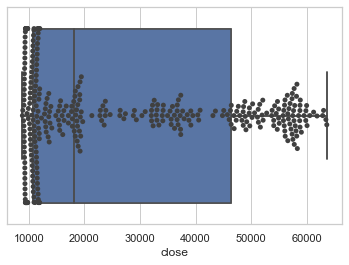

In [10]:
# detect outliers  (https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

sns.set_theme(style="whitegrid")
sns.boxplot(alldata['close'])
sns.set(rc={'figure.figsize':(8,4)})

# show points
ax = sns.boxplot(x="close", data=alldata)
ax = sns.swarmplot(x="close", data=alldata, color=".25")

#no outliers

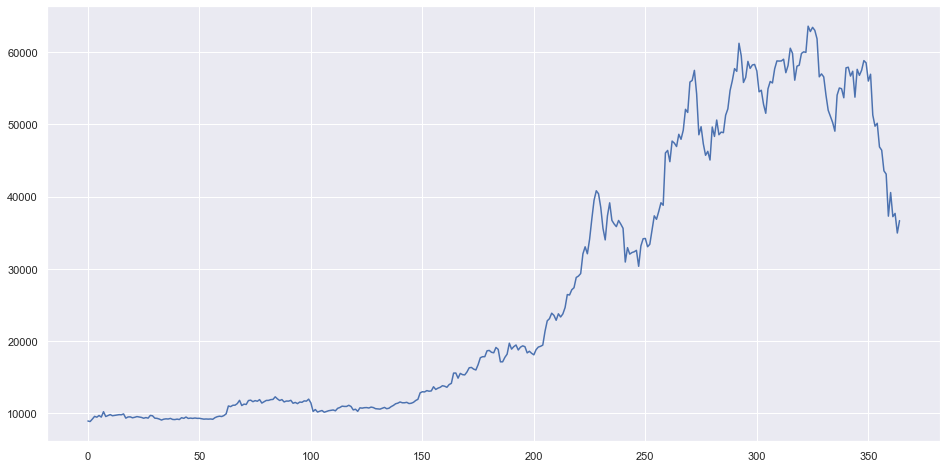

In [11]:
# show closing values over last year
plt.figure(figsize=(16,8))
plt.plot(alldata['close'])
plt.show()

## Model 1: Classification Tree
#### We want to know if the currency is ascending or descending the next day

In [12]:
def reg_metrics(y_test, y_pred, X_train):

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)
    
    return adj_r_sq

In [13]:
# select test data
numberOfTestData = int(0.2 * len(alldata))

# select feature col
feature_cols = ['close', 'variance', 'volume']
#feature_cols = ['close']

X = alldata[feature_cols]       # Features
y = alldata['pdctPositive']     # Target variable

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

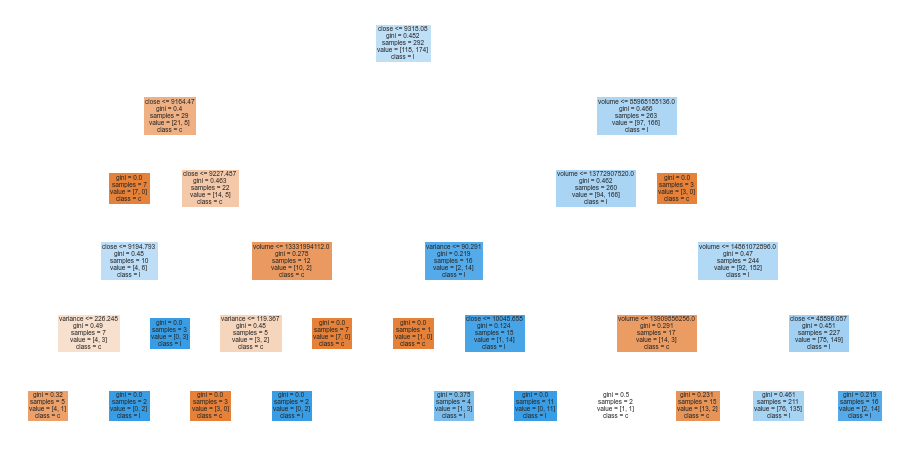

In [14]:
# show tree
fig = plt.figure(figsize=(16,8))
_ = tree.plot_tree(clf, 
                   feature_names=feature_cols,
                   class_names='close',
                   filled=True)

In [15]:
# Model Accuracy, how often is the classifier correct?
#accuracy = reg_metrics(y_test, y_pred, X_train)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("model accuracy is " + str(accuracy))

model accuracy is 0.4794520547945205


## Model 2: Linear Regression
#### We want to predict the currency

In [140]:
future_days = 25 # prediction over 25 days

# prepare arrays
alldataFrame = pd.DataFrame(alldata[['close']])

alldataFrame['prediction'] = alldataFrame[['close']].shift(-future_days)
X = np.array(alldataFrame.drop(['prediction'], 1))[:-future_days]
y = np.array(alldataFrame['prediction'])[:-future_days]

#plt.figure(figsize=(16,8))
#plt.plot(alldataFrame['close'], 'blue')
#plt.plot(alldataFrame['prediction'], 'red')

In [141]:
# split data into 75% training and 25% testing
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

#### predict the future

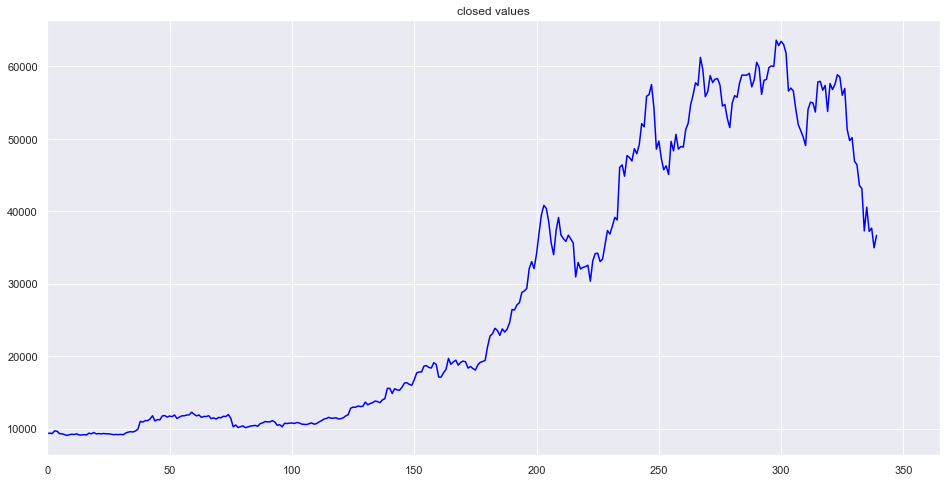

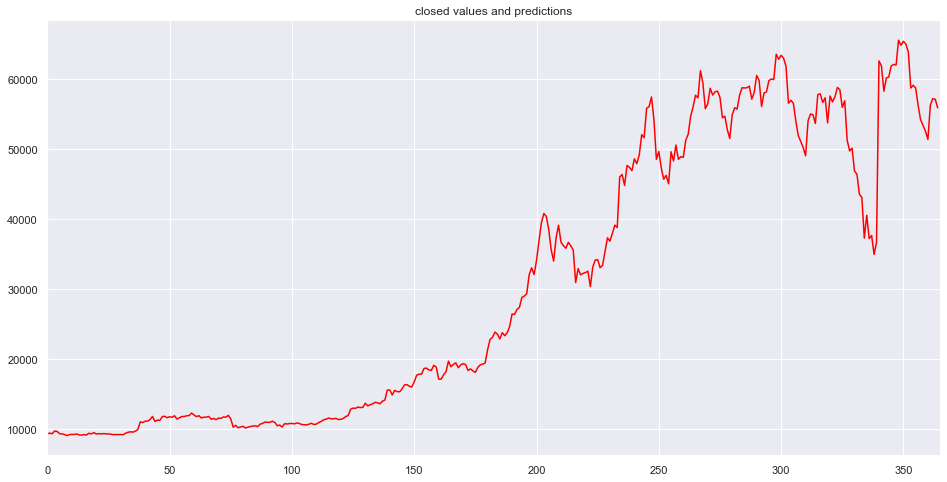

In [142]:
model = LinearRegression().fit(x_train, y_train)

# get last x rows
x_future = alldataFrame.drop(['prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)

# make prediction
prediction = model.predict(x_future)

# fill dataframe with the closing values
newPrediction = []
for i in range(0, len(alldataFrame['prediction']) - len(prediction)):
    newPrediction.append(alldataFrame['prediction'][i])
    
# append the predictions to dataframe
for i in range(0, len(prediction)):
    newPrediction.append(prediction[i])
    
# synchronize the two data sets (close and prediction)
alldataFrame['prediction'] = newPrediction
alldataFrame['close'] = alldataFrame['close'].shift(-future_days)

# show
plt.figure(figsize=(16,8))
plt.xlim([0, 365])
plt.title("closed values")
plt.plot(alldataFrame['close'], 'blue')
plt.figure(figsize=(16,8))
plt.title("closed values and predictions")
plt.plot(alldataFrame['prediction'], 'red')
plt.xlim([0, 365])
plt.show()

<ipython-input-122-10a180636873>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = lr_prediction


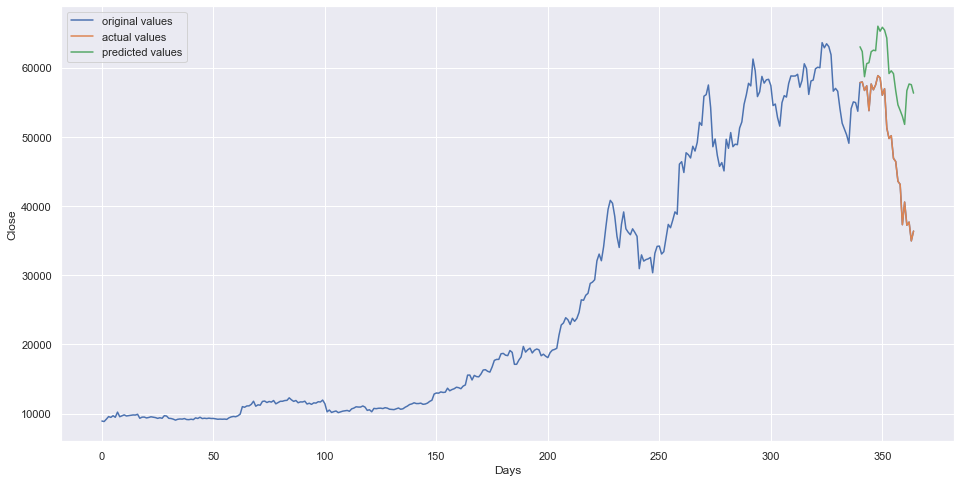

In [122]:
# show
lr_prediction = lr.predict(x_future)

valid = alldataFrame[X.shape[0]:]
valid['Prediction'] = lr_prediction
plt.figure(figsize=(16,8))

plt.xlabel('Days')
plt.ylabel('Close')
plt.plot(alldataFrame['close'])
plt.plot(valid[['close', 'Prediction']])
plt.legend(['original values', 'actual values', 'predicted values'])
plt.show()

In [127]:
# TODO: Beni: fix this


## Model 3: Neural Network
#### We want to predict the currency

In [34]:
# data: take only close-price
alldata = []
for i in range(1,len(hist)):
    alldata.append({
        "close": hist[i]['close']
    })
alldataFrame = pd.DataFrame(alldata)

In [35]:
# use scaler to reshape the data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(alldataFrame.values)

In [36]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

# preprocess data
SEQ_LEN = 100
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)

# show train / test data split
print(X_train.shape)
print(X_test.shape)

(224, 99, 1)
(40, 99, 1)


In [40]:
# settings
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 64

# create model
model = keras.Sequential()
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# fit model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/10
4/4 [==============================] - 9s 829ms/step - loss: 0.0185 - val_loss: 0.0040
Epoch 2/10
4/4 [==============================] - 1s 305ms/step - loss: 0.0359 - val_loss: 0.1709
Epoch 3/10
4/4 [==============================] - 1s 300ms/step - loss: 0.0153 - val_loss: 0.0015
Epoch 4/10
4/4 [==============================] - 1s 323ms/step - loss: 0.0277 - val_loss: 0.0338
Epoch 5/10
4/4 [==============================] - 1s 293ms/step - loss: 0.0145 - val_loss: 0.0096
Epoch 6/10
4/4 [==============================] - 1s 294ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 7/10
4/4 [==============================] - 1s 302ms/step - loss: 0.0025 - val_loss: 0.0358
Epoch 8/10
4/4 [==============================] - 1s 300ms/step - loss: 0.0048 - val_loss: 0.0251
Epoch 9/10
4/4 [==============================] - 1s 287ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/10
4/4 [==============================] - 1s 295ms/step - loss: 0.0033 - val_loss: 0.0073


In [173]:
# show model error
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 45ms/step - loss: 0.0125


0.012531690299510956

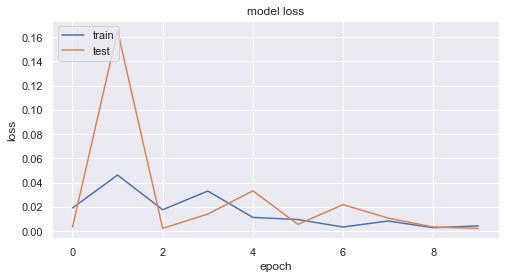

In [174]:
# plot model evolution
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

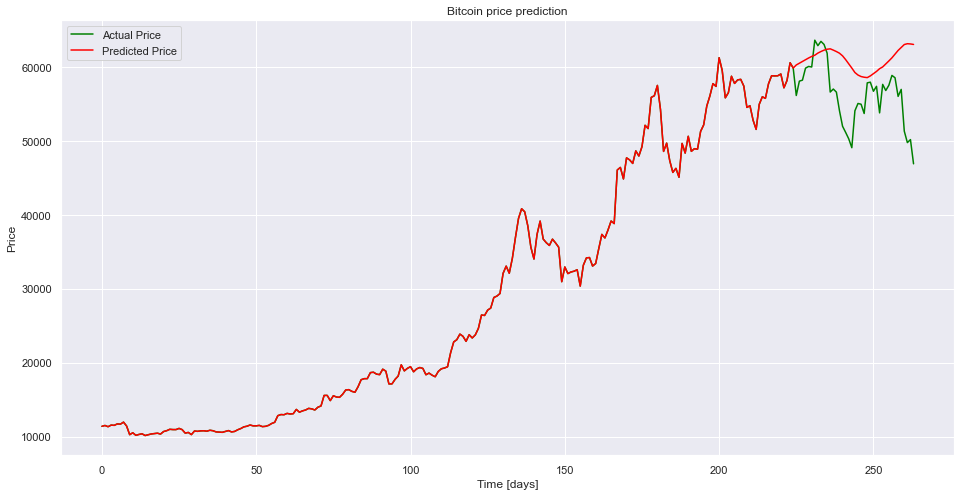

In [175]:
y_hat = model.predict(X_test)

y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)


y_testclose = []
for i in range(0, len(y_test_inverse)):
    y_testclose.append(y_test_inverse[i][0])
    
scale = y_test_inverse[0][0] / y_test[0][0]
y_predictclose = []
for i in range(0, len(y_hat)):
    y_predictclose.append(y_hat[i] * scale)
 

#alldata
y_actual_complete = []
y_predict_complete = []
for i in range(0, (len(y_train_inverse) + len(y_test_inverse))):
    if i < len(y_train_inverse):
        y_actual_complete.append(y_train_inverse[i])
        y_predict_complete.append(y_train_inverse[i])
    else:
        y_actual_complete.append(y_test_inverse[(i - len(y_train_inverse))])
        y_predict_complete.append(y_predictclose[(i - len(y_train_inverse))])


plt.figure(figsize=(16,8))
plt.plot(y_actual_complete, label="Actual Price", color='green')
plt.plot(y_predict_complete, label="Predicted Price", color='red')
    
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();